# Excitation-number-restricted states: Jaynes-Cummings Chain

### Authors: Robert Johansson### Authors: Robert Johansson (jrjohansson@gmail.com) and Neill Lambert (nwlambert@gmail.com)

## Introduction

The ENR functions construct a basis set for multipartite systems which contains only states that have an overall number of excitations.
This is particularly useful for systems where the model conserves excitation number, as in the JC-chain example below.

We can see this by considering a system consisting of 4 modes, each with 5 states.
The total hilbert space size is $5^4 = 625$.
If we are only interested in states that contain up to 2 excitations, we only need to include states such as


    (0, 0, 0, 0)
    (0, 0, 0, 1)
    (0, 0, 0, 2)
    (0, 0, 1, 0)
    (0, 0, 1, 1)
    (0, 0, 2, 0)
    ...

The ENR fucntions create operators and states for the 4 modes that act within this state space.
For example,

```python
a1, a2, a3, a4 = enr_destroy([5, 5, 5, 5], excitations=2)
```

creates destruction operators for each mode.
From this point onwards, the annihiltion operators a1, ..., a4 can be used to setup a Hamiltonian, collapse operators and expectation-value operators, etc., following the usual patterne.

In this example we outline the advantage of ENR states by comparing them with the regular qutip implementation.
For this we calculate the time evolution and the partial trace for each and see consistent results with notable performance improvements.

#### Be aware!

Many default functions in QuTiP will fail on states and operators constructed with this method.
Additionally, using this formalism, annihilation and creation operators of different sub-systems no longer commute.
Therefore, when constructing Hamiltonians, annihilation operators must be on the right and creation operators on the left (see the offical publication for QuTiP v5 for more info). 
To find all available functions to work with ENR states see [Energy Restricted Operators in the official documentation](https://qutip.readthedocs.io/en/qutip-5.0.x/apidoc/functions.html#module-qutip.core.energy_restricted).

In [82]:
import numpy as np
from qutip import (basis, tensor, identity, destroy, mesolve, liouvillian_ref, plot_expectation_values,
                   enr_destroy, enr_fock, enr_state_dictionaries, Qobj, Options)

%matplotlib inline

## The Jaynes-Cumming Chain

The general Jaynes-Cumming model describes a single two-level atom interacting with a single electromagnetic cavity mode.
For this example, we put multiple of these systems in a chain and let them interact with neighbouring systems via their cavities.
We use $a_i$ ($a^\dag_i$) as annihilation (creation) operators for the cavity $i$ and $s_i$ ($s^\dag_i$) for the atoms.
We then model the complete Hamiltonian by splitting it into the individual systems:

$H_0 = \sum_{i=0}^{N} a_i^\dag a_i + s_i^\dag s_i$,

the atom-cavity interactions:

$H_{int,AC} = \sum_{i=0}^{N} = \frac{1}{2} (a_i^\dag s_i + s_i^\dag a_i)$,

and the cavity-cavity interactions:

$H_{int,CC} = \sum_{i=0}^{N-1} 0.9 \cdot (a_i^\dag a_{i+1} + a_{i+1}^\dag a_{i})$,

where the interaction strength of $0.9$ was chosen arbitrarily.

### Problem paramters

In [99]:
N = 4               # number of systems
M = 2               # number of cavity states
dims = [M, 2] * N   #dimensions of JC spin chain
excite = 1          # total number of excitations
init_excite = 1     # initial number of excitations

### Setup to Calculate Time Evolution

In [98]:
def solve(d, psi0):
    # annihilation operators for cavity modes
    a = d[::2]
    # atomic annihilation operators
    sm = d[1::2]

    # when constructing the Hamiltonian notice the ordering of annihilation and creation operators (see introduction)
    H0 = sum([aa.dag() * aa for aa in a]) + sum([s.dag() * s for s in sm])

    # atom-cavity couplings
    Hint_ac = 0
    for n in range(N):
        Hint_ac += 0.5 * (a[n].dag() * sm[n] + sm[n].dag() * a[n])

    # cavity-cavity couplings
    Hint_cc = 0
    for n in range(N-1):
        Hint_cc += 0.9 * (a[n].dag() * a[n+1] + a[n+1].dag() * a[n])

    H = H0 + Hint_ac + Hint_cc

    e_ops = [x.dag() * x for x in d]
    c_ops = [0.01 * x for x in a]

    times = np.linspace(0, 250, 1000)
    L = liouvillian_ref(H, c_ops)
    result = mesolve(H, psi0, times, c_ops, e_ops, options=Options(nsteps=5000,store_states=True))
    return result, H, L

### Regular QuTiP States and Operators

In [100]:
d = [tensor([destroy(dim1) if idx1 == idx2 else identity(dim1) for idx1, dim1 in enumerate(dims)]) for idx2, _ in enumerate(dims)]
psi0 = tensor([basis(dim, init_excite) if idx == 1 else basis(dim, 0) for idx, dim in enumerate(dims)])

In [101]:
%time res1, H1, L1 = solve(d, psi0)

CPU times: user 38.3 s, sys: 30.8 ms, total: 38.3 s
Wall time: 38.6 s


### Using ENR States

In [87]:
d = enr_destroy(dims, excite)
psi0 = enr_fock(dims, excite, [init_excite if n == 1 else 0 for n in range(2*N)])

In [97]:
%time res2, H2, L2 = solve(d, psi0)

CPU times: user 95.7 ms, sys: 23 µs, total: 95.7 ms
Wall time: 93.3 ms


### Comparison of Expectation Values

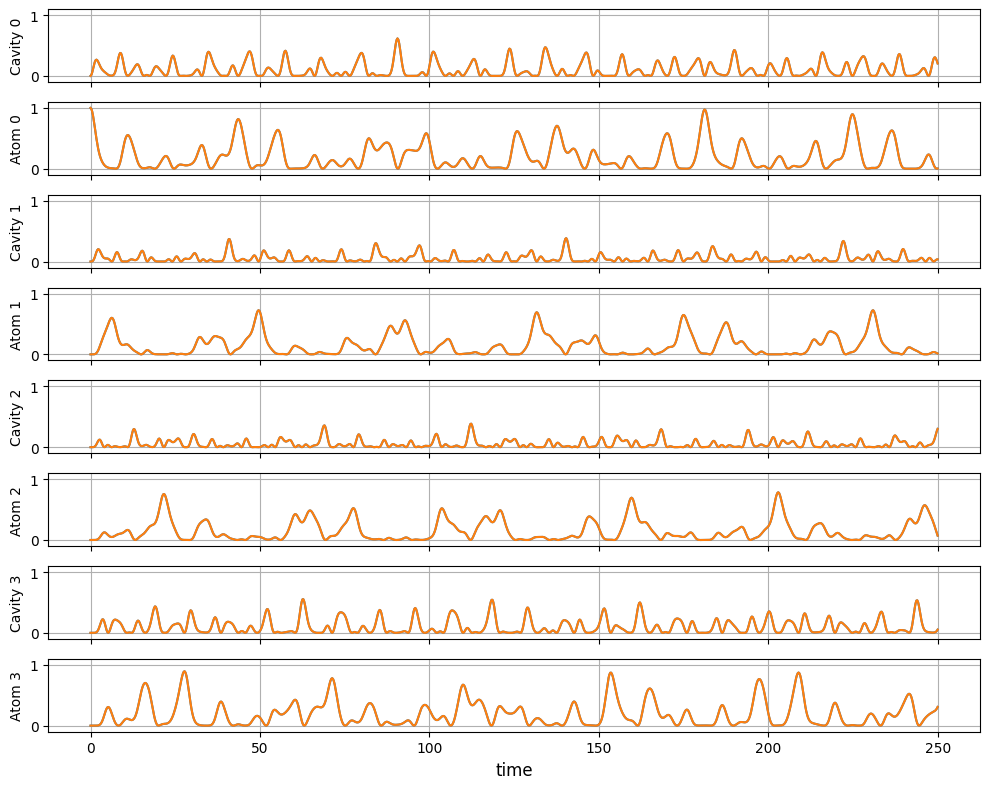

In [108]:
fig, axes = plot_expectation_values([res1, res2], figsize=(10,8))
for idx, ax in enumerate(axes[:, 0]):
    if idx%2:   ax.set_ylabel(f"Atom {idx//2}")
    else:       ax.set_ylabel(f"Cavity {idx//2}")
    ax.set_ylim(-.1, 1.1)
    ax.grid()
fig.tight_layout()

### Calculation of Partial Trace

The usage of ENR states makes many standard QuTiP features fail.
```ptrace``` is one of those.
Below we demonstrate how the partial trace for ENR states can be calculated and show the corresponding result to the standrad QuTiP approach.

In [90]:
def ENR_ptrace(rho, sel, excitations):
    if isinstance(sel, int):
        sel = np.arrau([sel])
    else:
        sel = np.asarray(sel)

    if (sel < 0).any() or (sel >= len(rho.dims[0])).any():
            raise TypeError("Invalid selection index in ptrace.")

    drho = rho.dims[0]
    nstates, state2idx, idx2state = enr_state_dictionaries(drho, excitations)

    dims_short = np.asarray(drho).take(sel)
    nstates2, state2idx2, idx2state2 = enr_state_dictionaries(dims_short.tolist(), excitations)

    # dimensions of traced out system
    rest = np.setdiff1d(np.arange(len(drho)), sel)

    # construct new density matrix
    rhout = np.zeros((nstates2, nstates2), dtype=np.complex64)

    for state in idx2state:
        for state2 in idx2state:
            #if the parts of the states of the systems(s) being traced out are diagonal, add this to the new DM
            if  np.all(np.asarray(state).take(rest) == np.asarray(state2).take(rest)):
                rhout[state2idx2[tuple(np.asarray(state).take(sel))],
                      state2idx2[tuple(np.asarray(state2).take(sel))]] += rho.data[state2idx[state],
                                                                                    state2idx[state2]]

    dims_kept0 = np.asarray(drho).take(sel)
    rho1_dims = [dims_kept0.tolist(), dims_kept0.tolist()]
    rho1_shape = [nstates2, nstates2]
    
    return Qobj(rhout,rho1_dims,rho1_shape)

In [91]:
res1.states[10].ptrace([1])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.90140958 0.        ]
 [0.         0.09859042]]

In [92]:
ENR_ptrace(res2.states[10], [0], excite)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.09879421 0.        ]
 [0.         0.90120578]]

In [93]:
res1.states[10].ptrace([0,1,4])

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[9.52974830e-05+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  9.85904167e-02+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.29819814j 0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00-0.29819814j 0.00000000e+00+0.

In [94]:
ENR_ptrace(res2.states[10], [0,1,4], excite)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[9.52936316e-05+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  9.86989141e-02+0.j         0.00000000e+00+0.29823667j]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00-0.29823667j 9.01205778e-01+0.j        ]]